# Tiled image processing, a quick run-through

In this notebook we will process a big dataset that has been saved in zarr format to count cells in individual tiles using [dask](https://docs.dask.org/en/stable/) and [zarr](https://zarr.readthedocs.io/en/stable/). The underlying principles will be explained in the next sections.

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

For demonstration purposes, we use a dataset that is provided by Theresa Suckert, OncoRay, University Hospital Carl Gustav Carus, TU Dresden. The dataset is licensed [License: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). We are using a cropped version here that was resaved a 8-bit image to be able to provide it with the notebook. You find the full size 16-bit image in CZI file format [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ). The biological background is explained in [Suckert et al. 2020](https://www.sciencedirect.com/science/article/abs/pii/S0167814020301043), where we also applied a similar workflow. 

When working with big data, you will likely have an image stored in the right format to begin with. For demonstration purposes, we save here a test image into the zarr format, which is commonly used for handling big image data.

In [2]:
# Resave a test image into tiled zarr format
input_filename = '../../data/P1_H_C3H_M004_17-cropped.tif'
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
image = imread(input_filename)[1]
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
zarray = zarr.array(image, chunks=(100, 100), compressor=compressor)
zarr.convenience.save(zarr_filename, zarray)

## Loading the zarr-backed image
Dask brings built-in support for the zarr file format. We can create dask arrays directly from a zarr file.

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(2000, 5000), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

We can apply image processing to this tiled dataset directly.

## Counting nuclei
For counting the nuclei, we setup a simple image processing workflow. It returns an image with a single pixel containing the number of nuclei in the given input image. These single pixels will be assembled to a pixel count map; an image with much less pixels than the original image, but with the advantage that we can look at it - it's no big data anymore.cle.exclude_labels_with_map_values_within_range

In [4]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    # Count nuclei including those which touch the image border
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    label_intensity_map = cle.mean_intensity_map(image, labels)
    
    high_intensity_labels = cle.exclude_labels_with_map_values_within_range(label_intensity_map, labels, maximum_value_range=20)
    nuclei_count = high_intensity_labels.max()
    
    # Count nuclei excluding those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(high_intensity_labels)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    return result

Before we can start the computation, we need to deactivate asynchronous execution of operations in pyclesperanto. [See also related issue](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163).

In [5]:
cle.set_wait_for_kernel_finish(True)

For processing tiles using dask, we setup processing blocks with no overlap.

In [6]:
tile_map = da.map_blocks(count_nuclei, zarr_image)

tile_map

dask.array<count_nuclei, shape=(2000, 5000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

As the result image is much smaller then the original, we can compute the whole result map.

In [7]:
result = tile_map.compute()

In [8]:
result.shape

(20, 50)

Again, as the result map is small, we can just visualize it.

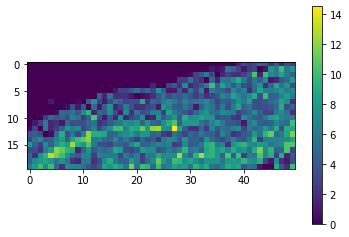

In [9]:
cle.imshow(result, colorbar=True)

With a quick visual check in the original image, we can see that indeed in the top left corner of the image, there are much less cells than in the bottom right.

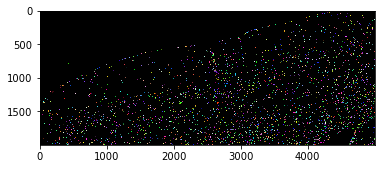

In [10]:
cle.imshow(cle.voronoi_otsu_labeling(image, spot_sigma=3.5), labels=True)